# Time Series Distance Measures

In [113]:
!git clone https://github.com/TDAmeritrade/stumpy.git
!git clone https://github.com/spatialaudio/python-sounddevice.git
!git clone https://github.com/PortAudio/portaudio.git
!git clone https://github.com/MTG/essentia.git
!git clone https://github.com/librosa/librosa

!pip install essentia
!pip install librosa
!pip install portaudio
!pip install sounddevice
!pip install fastdtw

import datetime
import matplotlib.pyplot as plt
import time as timepackage
import librosa
import numpy as np
import pandas as pd
import scipy
import stumpy
from scipy.spatial import distance
from scipy.interpolate import interp1d
#!pip install libportaudio2
import sounddevice as sd
from fastdtw import fastdtw

## 1. Load Data

Load annotations, pitch time series, and audio

#### Loud Annotations

In [2]:
annotations_path = 'koti_janmani_annotations.txt'

In [3]:
annotations = pd.read_csv(annotations_path, sep='\t', header=None)
annotations.columns = ['level','','start','end','duration','label']

In [4]:
# redundant column
del annotations['']

In [5]:
annotations

,level,start,end,duration,label
0,sancara,00:00:01.985,00:00:05.238,00:00:03.253,nnsnndm
1,sancara,00:00:05.238,00:00:08.300,00:00:03.062,mgmpmmgrg
2,sancara,00:00:12.492,00:00:17.059,00:00:04.567,gssnnndpdndm
3,sancara,00:00:17.059,00:00:18.776,00:00:01.717,mgmpmpgr
4,sancara,00:00:21.417,00:00:24.871,00:00:03.454,gmpdpdndmpgr
...,...,...,...,...,...
431,underlying_full_phrase,00:07:32.423,00:07:36.867,00:00:04.444,ssnsrsndmmgmpmggrs
432,underlying_full_phrase,00:07:37.812,00:07:42.967,00:00:05.155,grsssnrsnndmgmn
433,underlying_full_phrase,00:07:43.194,00:07:47.639,00:00:04.445,ssnsrsndmmgmpmggrs
434,underlying_full_phrase,00:07:53.418,00:07:59.629,00:00:06.211,nrsnsndmgmpmgrgmgmn


Isolate level of interest. Some annotations overlap, those with 'underlying' in level refer to less granular annotations

In [6]:
annotations = annotations[annotations['level']=='underlying_sancara'].reset_index()

Start and end times are in HH:MM:SS:ms format. Convert to seconds.

In [7]:
annotations['start'] = pd.to_datetime(annotations['start'])
annotations['end'] = pd.to_datetime(annotations['end'])

In [8]:
def convert_dt(dt):
    return (dt.hour * 60 * 60) + (dt.minute * 60) + (dt.second) + (dt.microsecond * 0.000001)

In [9]:
annotations['start'] = annotations['start'].apply(convert_dt)
annotations['end'] = annotations['end'].apply(convert_dt)

In [10]:
annotations

,index,level,start,end,duration,label
0,164,underlying_sancara,5.238,8.300,00:00:03.062,mgmpmmgrg
1,165,underlying_sancara,69.100,72.285,00:00:03.185,mmgmpgpmgrs
2,166,underlying_sancara,72.506,75.230,00:00:02.724,sssnnpn
3,167,underlying_sancara,75.428,78.776,00:00:03.348,smmggmggrs
4,168,underlying_sancara,80.928,84.014,00:00:03.086,mmgmpgpmgrs
...,...,...,...,...,...,...
133,297,underlying_sancara,478.819,479.614,00:00:00.795,gmn
134,298,underlying_sancara,479.714,481.314,00:00:01.600,nrsssndm
135,299,underlying_sancara,481.314,484.072,00:00:02.758,mmgmpgpmgrs
136,300,underlying_sancara,484.072,486.985,00:00:02.913,sssnnpn


#### Load Pitch Time Series

In [11]:
pitch_path = 'koti_janmani_pitch.txt'

In [12]:
pitch_track = pd.read_csv(pitch_path, header=None, sep='\t')
pitch_track.columns = ['time', 'pitch']

In [13]:
pitch_track

,time,pitch
0,0.000000,0.0
1,0.004444,0.0
2,0.008889,0.0
3,0.013333,0.0
4,0.017778,0.0
...,...,...
118506,526.693333,0.0
118507,526.697778,0.0
118508,526.702222,0.0
118509,526.706667,0.0


Isolate pitch and time arrays. Infer timestep from time track

In [14]:
time = pitch_track['time'].values
pitch = pitch_track['pitch'].values
timestep = time[1]-time[0]

In [ ]:
timestep

#### Load audio

In [15]:
pitch_path = 'koti_janmani_audio.mp3'
sr = 44100
y, _ = librosa.load(pitch_path, sr=sr)

In [16]:
y

array([ 0.000000e+00,  0.000000e+00,  0.000000e+00, ..., -4.512861e-04,
       -9.446638e-05,  6.142099e-04], dtype=float32)

## 2. Get Observation

Take one example from the annotations and get the start time, end time, and pattern label

In [110]:
i = 0
row = annotations.iloc[i]

In [111]:
s1 = row.start
s2 = row.end
label = row.label
row

index                      164
level       underlying_sancara
start                    5.238
end                        8.3
duration          00:00:03.062
label                mgmpmmgrg
Name: 0, dtype: object

#### Chop Times Series

Chop original pitch and time time series to get the region that corresponds to observation

In [19]:
s1_ix = round(s1/timestep) # NUMBER OF ELEMENTS of pitch_track in s1 seconds (5.238)
s2_ix = round(s2/timestep)

s1_sr = round(s1*sr)
s2_sr = round(s2*sr)

In [20]:
pitch_samp = pitch[s1_ix:s2_ix] # SEGMENT of our pitch_track for row 1
time_samp = time[s1_ix:s2_ix]
audio_samp = y[s1_sr:s2_sr]

In [1]:
len(pitch_samp)*timestep

NameError: name 'pitch_samp' is not defined

Wrap previous code in a function

In [21]:
def get_obs(i, pitch, time, annotations, timestep):
    row = annotations.iloc[i]
    s1 = row.start
    s2 = row.end
    label = row.label
    
    s1_ix = round(s1/timestep)
    s2_ix = round(s2/timestep)
    
    pitch_samp = pitch[s1_ix:s2_ix]
    time_samp = time[s1_ix:s2_ix]
    
    return pitch_samp, time_samp, label

#### Plot Time Series and Listen to Audio

Text(0.5, 0, 'Time (s)')

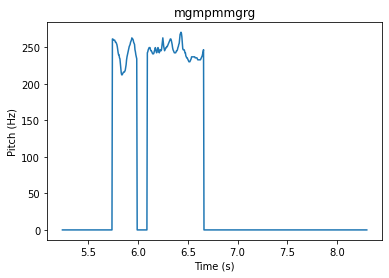

In [22]:
plt.plot(time_samp, pitch_samp)
plt.title(f'{label}')
plt.ylabel('Pitch (Hz)')
plt.xlabel('Time (s)')

In [23]:
# play audio
sd.play(audio_samp, sr)

Is this pitch time series correct? How could we improve it? (e.g. Interpolate incorrectly annotated silence, smooth, trim leading and trailing silence, convert to cents?)

## 3. Euclidean Distance

Euclidean distance compares element i in time series 1 with element i in time series 2 for i in range(len(time series)) and sums.

In [24]:
i1 = 125
i2 = 120

In [25]:
row = annotations.iloc[i1]
s1 = row.start
s2 = row.end
label = row.label

s1_ix = round(s1/timestep)
s2_ix = round(s2/timestep)

pitch_samp = pitch[s1_ix:s2_ix]
time_samp = time[s1_ix:s2_ix]

In [26]:
row

index                      289
level       underlying_sancara
start                  457.789
end                    459.774
duration          00:00:01.985
label                     grss
Name: 125, dtype: object

In [27]:
p1, t1, l1 = get_obs(i1, pitch, time, annotations, timestep)
p2, t2, l2 = get_obs(i2, pitch, time, annotations, timestep)

Text(0.5, 0, 'Time (s)')

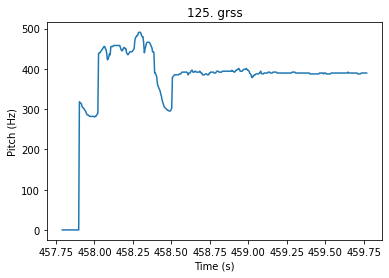

In [28]:
plt.plot(t1, p1)
plt.title(f'{i1}. {l1}')
plt.ylabel('Pitch (Hz)')
plt.xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

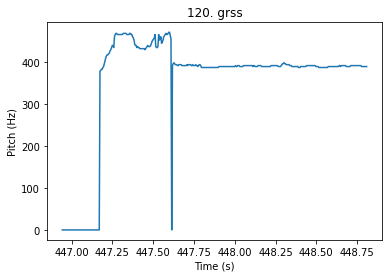

In [29]:
plt.plot(t2, p2)
plt.title(f'{i2}. {l2}')
plt.ylabel('Pitch (Hz)')
plt.xlabel('Time (s)')

In [30]:
distance.euclidean(p1, p2)

ValueError: operands could not be broadcast together with shapes (446,) (421,) 

In [31]:
distance.euclidean(p1, p1)

0.0

How could we compare time series of different lengths? Hint: resample

## 4. Dynamic Time Warping

Dynamic time warping allows us to handle time series of different lengths.

In [47]:
dist, path = fastdtw(p1, p2)
dist_norm = dist/len(path)

Plot warping path

Text(0, 0.5, 'pattern 1 element')

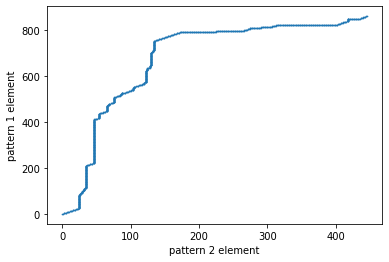

In [48]:
plt.scatter([x[0] for x in path], [x[1] for x in path], s=0.5)
plt.xlabel('pattern 2 element')
plt.ylabel('pattern 1 element')

#### Compare to all

Lets compare pattenr p1 to all other patterns in the dataset. Which are the closest? Do they have the same pattern label?

In [35]:
# IMPORTANT: this is used to compare one annotation with all and compute similarity between the using DTW

all_dist = []
for i in annotations.index:
    # chop the time series - get sample
    p2, t2, l2 = get_obs(i, pitch, time, annotations, timestep) # returns pitch, time, label
    dist, path = fastdtw(p1, p2)
    dist_norm = dist/len(path)
    all_dist.append((i,dist_norm,l2))

In [36]:
l1

'grss'

In [37]:
sorted(all_dist, key=lambda y: y[1])

[(125, 0.0, 'grss'),
 (61, 5.874175824617085, 'grss'),
 (56, 7.0353935530786655, 'grss'),
 (120, 9.074164868126903, 'grss'),
 (46, 16.59117587271579, 'nnsns'),
 (98, 19.540392293226, 'nns'),
 (51, 21.044295253665496, 'grss'),
 (100, 21.41372569421372, 'nnsns'),
 (39, 21.9077400783588, 'nns'),
 (113, 22.75731295387217, 'nns'),
 (115, 25.165897598025925, 'grss'),
 (37, 25.793239146396704, 'nnsns'),
 (16, 28.31040620803833, 'mnnssss'),
 (103, 28.48221363294993, 'nns'),
 (110, 29.740939977047216, 'nnsns'),
 (64, 30.050147362834405, 'ssnsrsndm'),
 (105, 33.68366438415708, 'nnsns'),
 (68, 38.07238459123884, 'nrsnsndm'),
 (50, 38.32062890863574, 'sssndmnnsns'),
 (44, 46.09801498959069, 'nns'),
 (67, 46.198306067872444, 'mnnssss'),
 (36, 46.25628819687231, 'sssndm'),
 (133, 46.29308588616202, 'gmn'),
 (114, 46.915943163013026, 'sssndmnnsns'),
 (137, 47.214068172812574, 'smmggmggrs'),
 (108, 50.44104170840011, 'nns'),
 (128, 50.4912232334174, 'ssnsrsndm'),
 (130, 51.1806125220943, 'mnnssss'),
 

## 5. Matrix Profile

The matrix profile allows us to compute distances across the pitch track as a whole. A full tutorial can be found here - https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html

#### MASS query algorithm

The mass algorithm allows us to compare a query pattern to the entire pitch track

In [116]:
distance_profile = stumpy.mass(p1, pitch, normalize=False)

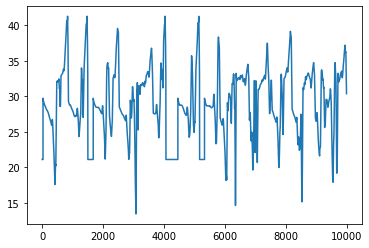

In [61]:
plt.plot(distance_profile[:10000])

Minimums in this distance profile correspond to regions that are most similar to the query pattern

In [62]:
distance_profile.argmin()

103003

#### Full Matrix Profile

The stump algorithm computes the distance between each pairwise combination of regions in pitch. A full overview of the matrix profile is available here - https://www.cs.ucr.edu/~eamonn/Matrix_Profile_Tutorial_Part1.pdf.

"The matrix profile at the ith location records the distance of the subsequence in T, at the ith location, to its nearest neighbor under z-normalized Euclidean Distance"

In [114]:
l = 800 # Which length pattern are we looking for

In [115]:
mp = stumpy.stump(pitch, l, normalize=False)

In [105]:
motif_idx = np.argsort(mp[:, 0])[20000]

In [106]:
print(f"The motif is located at index {motif_idx}")

The motif is located at index 20142


In [107]:
nearest_neighbor_idx = mp[motif_idx, 1]

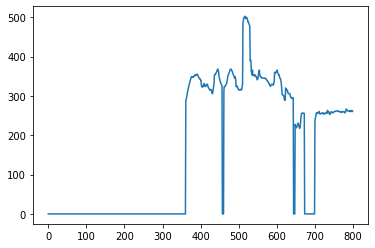

In [108]:
plt.plot(pitch[motif_idx:motif_idx+l])

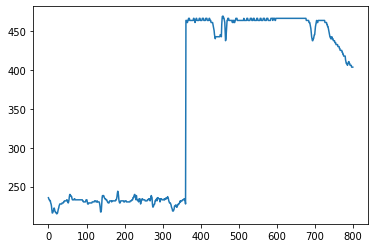

In [109]:
plt.plot(pitch[nearest_neighbor_idx:nearest_neighbor_idx+l])